In [1]:
import os
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Set paths for train and test data
data_dir = "./data"  # Assuming "data" folder is in the same directory as the notebook
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transformations for Inception V3
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),  # Resize for Inception V3
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [3]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # used to be 32
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # used to be 32

# Get class names
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
# Load pretrained Inception V3 model
inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Freeze feature extraction layers (optional for transfer learning)
for param in inception_v3.parameters():
    param.requires_grad = False

# Modify the classifier for your dataset
num_classes = len(class_names)
inception_v3.fc = nn.Linear(in_features=2048, out_features=num_classes)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_v3 = inception_v3.to(device)

print("Model successfully loaded and modified.")
print(device)

Model successfully loaded and modified.
cuda


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_v3.parameters(), lr=5e-4)

In [6]:
def test_model(model, get_cm_data=True):
    train_correct = 0
    train_total = 0
    
    test_correct = 0
    test_total = 0

    _train_label_true = []
    _train_label_pred = []
    
    _test_label_true = []
    _test_label_pred = []
    
    model.eval()
    
    with torch.inference_mode():
        for _inputs, _labels in train_loader:
            _inputs, _labels = _inputs.to(device), _labels.to(device)
            _outputs = model(_inputs)
            if isinstance(_outputs, tuple):  # For Inception V3
                _outputs = _outputs[0]
            _, preds = torch.max(_outputs, 1)
            train_correct += (preds == _labels).sum().item()
            train_total += _labels.size(0)
            if get_cm_data:
                _train_label_true.append(_labels)
                _train_label_pred.append(preds)
    
        for _inputs, _labels in test_loader:
            _inputs, _labels = _inputs.to(device), _labels.to(device)
            _outputs = model(_inputs)
            if isinstance(_outputs, tuple):  # For Inception V3
                _outputs = _outputs[0]
            _, preds = torch.max(_outputs, 1)
            test_correct += (preds == _labels).sum().item()
            test_total += _labels.size(0)
            if get_cm_data:
                _test_label_true.append(_labels)
                _test_label_pred.append(preds)
    
    _train_accuracy = (train_correct / train_total) * 100
    _test_accuracy = (test_correct / test_total) * 100
    
    return _train_accuracy, _test_accuracy, _train_label_true, _train_label_pred, _test_label_true, _test_label_pred

In [7]:
# Training loop
num_epochs = 40

train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    inception_v3.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = inception_v3(inputs)
        if isinstance(outputs, tuple):  # Primary and auxiliary outputs for Inception V3
            main_outputs, aux_outputs = outputs
            loss = criterion(main_outputs, labels) + 0.4 * criterion(aux_outputs, labels)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy, test_accuracy, train_label_true, train_label_pred, test_label_true, test_label_pred = test_model(inception_v3, get_cm_data=False)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f} \n")
    
    torch.save(inception_v3.state_dict(), 'model_inception_v3.pth')
    
_, _, train_label_true, train_label_pred, test_label_true, test_label_pred = test_model(inception_v3, get_cm_data=True)

  2%|██                                                                                 | 1/40 [00:09<06:01,  9.26s/it]

Epoch 1/40
Training Loss: 5.5804
Training Accuracy: 29.3750
Testing Accuracy: 28.6432 



  5%|████▏                                                                              | 2/40 [00:18<05:51,  9.24s/it]

Epoch 2/40
Training Loss: 5.3348
Training Accuracy: 38.8750
Testing Accuracy: 39.6985 



  8%|██████▏                                                                            | 3/40 [00:27<05:36,  9.11s/it]

Epoch 3/40
Training Loss: 5.1789
Training Accuracy: 56.2500
Testing Accuracy: 47.2362 



 10%|████████▎                                                                          | 4/40 [00:36<05:22,  8.96s/it]

Epoch 4/40
Training Loss: 5.1079
Training Accuracy: 52.7500
Testing Accuracy: 45.2261 



 12%|██████████▍                                                                        | 5/40 [00:44<05:10,  8.88s/it]

Epoch 5/40
Training Loss: 4.9782
Training Accuracy: 58.7500
Testing Accuracy: 50.7538 



 15%|████████████▍                                                                      | 6/40 [00:53<04:59,  8.81s/it]

Epoch 6/40
Training Loss: 4.8669
Training Accuracy: 56.1250
Testing Accuracy: 45.7286 



 18%|██████████████▌                                                                    | 7/40 [01:02<04:49,  8.77s/it]

Epoch 7/40
Training Loss: 4.8313
Training Accuracy: 60.5000
Testing Accuracy: 48.2412 



 20%|████████████████▌                                                                  | 8/40 [01:10<04:39,  8.75s/it]

Epoch 8/40
Training Loss: 4.7798
Training Accuracy: 62.1250
Testing Accuracy: 50.7538 



 22%|██████████████████▋                                                                | 9/40 [01:19<04:32,  8.78s/it]

Epoch 9/40
Training Loss: 4.7655
Training Accuracy: 60.7500
Testing Accuracy: 49.2462 



 25%|████████████████████▌                                                             | 10/40 [01:28<04:22,  8.74s/it]

Epoch 10/40
Training Loss: 4.7066
Training Accuracy: 64.6250
Testing Accuracy: 52.7638 



 28%|██████████████████████▌                                                           | 11/40 [01:37<04:12,  8.71s/it]

Epoch 11/40
Training Loss: 4.6796
Training Accuracy: 68.6250
Testing Accuracy: 56.2814 



 30%|████████████████████████▌                                                         | 12/40 [01:45<04:03,  8.71s/it]

Epoch 12/40
Training Loss: 4.6488
Training Accuracy: 65.7500
Testing Accuracy: 53.2663 



 32%|██████████████████████████▋                                                       | 13/40 [01:54<03:54,  8.69s/it]

Epoch 13/40
Training Loss: 4.6213
Training Accuracy: 68.1250
Testing Accuracy: 53.2663 



 35%|████████████████████████████▋                                                     | 14/40 [02:03<03:46,  8.71s/it]

Epoch 14/40
Training Loss: 4.5843
Training Accuracy: 68.7500
Testing Accuracy: 58.7940 



 38%|██████████████████████████████▊                                                   | 15/40 [02:11<03:37,  8.70s/it]

Epoch 15/40
Training Loss: 4.5769
Training Accuracy: 72.1250
Testing Accuracy: 56.2814 



 40%|████████████████████████████████▊                                                 | 16/40 [02:20<03:30,  8.78s/it]

Epoch 16/40
Training Loss: 4.5305
Training Accuracy: 69.2500
Testing Accuracy: 56.7839 



 42%|██████████████████████████████████▊                                               | 17/40 [02:29<03:21,  8.74s/it]

Epoch 17/40
Training Loss: 4.5517
Training Accuracy: 72.6250
Testing Accuracy: 54.7739 



 45%|████████████████████████████████████▉                                             | 18/40 [02:38<03:12,  8.74s/it]

Epoch 18/40
Training Loss: 4.5534
Training Accuracy: 71.2500
Testing Accuracy: 54.2714 



 48%|██████████████████████████████████████▉                                           | 19/40 [02:46<03:03,  8.73s/it]

Epoch 19/40
Training Loss: 4.5293
Training Accuracy: 72.8750
Testing Accuracy: 56.2814 



 50%|█████████████████████████████████████████                                         | 20/40 [02:55<02:54,  8.72s/it]

Epoch 20/40
Training Loss: 4.5443
Training Accuracy: 74.7500
Testing Accuracy: 56.2814 



 52%|███████████████████████████████████████████                                       | 21/40 [03:04<02:45,  8.71s/it]

Epoch 21/40
Training Loss: 4.5115
Training Accuracy: 71.7500
Testing Accuracy: 57.2864 



 55%|█████████████████████████████████████████████                                     | 22/40 [03:13<02:36,  8.69s/it]

Epoch 22/40
Training Loss: 4.4646
Training Accuracy: 74.7500
Testing Accuracy: 56.7839 



 57%|███████████████████████████████████████████████▏                                  | 23/40 [03:21<02:28,  8.72s/it]

Epoch 23/40
Training Loss: 4.4442
Training Accuracy: 73.2500
Testing Accuracy: 55.2764 



 60%|█████████████████████████████████████████████████▏                                | 24/40 [03:30<02:19,  8.72s/it]

Epoch 24/40
Training Loss: 4.4689
Training Accuracy: 77.0000
Testing Accuracy: 55.7789 



 62%|███████████████████████████████████████████████████▎                              | 25/40 [03:39<02:10,  8.72s/it]

Epoch 25/40
Training Loss: 4.4176
Training Accuracy: 76.2500
Testing Accuracy: 56.2814 



 65%|█████████████████████████████████████████████████████▎                            | 26/40 [03:47<02:02,  8.73s/it]

Epoch 26/40
Training Loss: 4.3946
Training Accuracy: 75.0000
Testing Accuracy: 58.2915 



 68%|███████████████████████████████████████████████████████▎                          | 27/40 [03:56<01:53,  8.72s/it]

Epoch 27/40
Training Loss: 4.3987
Training Accuracy: 73.3750
Testing Accuracy: 58.2915 



 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [04:05<01:44,  8.69s/it]

Epoch 28/40
Training Loss: 4.4097
Training Accuracy: 75.8750
Testing Accuracy: 60.3015 



 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [04:13<01:35,  8.69s/it]

Epoch 29/40
Training Loss: 4.3948
Training Accuracy: 77.3750
Testing Accuracy: 59.7990 



 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [04:22<01:26,  8.66s/it]

Epoch 30/40
Training Loss: 4.3765
Training Accuracy: 78.0000
Testing Accuracy: 57.7889 



 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [04:31<01:18,  8.68s/it]

Epoch 31/40
Training Loss: 4.3630
Training Accuracy: 77.7500
Testing Accuracy: 56.7839 



 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [04:39<01:09,  8.67s/it]

Epoch 32/40
Training Loss: 4.3298
Training Accuracy: 79.0000
Testing Accuracy: 59.2965 



 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [04:48<01:00,  8.66s/it]

Epoch 33/40
Training Loss: 4.4038
Training Accuracy: 80.0000
Testing Accuracy: 61.3065 



 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [04:57<00:51,  8.66s/it]

Epoch 34/40
Training Loss: 4.3690
Training Accuracy: 78.8750
Testing Accuracy: 59.7990 



 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [05:05<00:43,  8.67s/it]

Epoch 35/40
Training Loss: 4.2993
Training Accuracy: 80.3750
Testing Accuracy: 59.2965 



 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [05:14<00:34,  8.68s/it]

Epoch 36/40
Training Loss: 4.3312
Training Accuracy: 79.1250
Testing Accuracy: 56.2814 



 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:23<00:26,  8.68s/it]

Epoch 37/40
Training Loss: 4.3233
Training Accuracy: 80.2500
Testing Accuracy: 60.8040 



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [05:32<00:17,  8.68s/it]

Epoch 38/40
Training Loss: 4.3491
Training Accuracy: 81.1250
Testing Accuracy: 56.2814 



 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [05:40<00:08,  8.69s/it]

Epoch 39/40
Training Loss: 4.2930
Training Accuracy: 80.2500
Testing Accuracy: 59.2965 



100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [05:49<00:00,  8.74s/it]

Epoch 40/40
Training Loss: 4.2738
Training Accuracy: 78.7500
Testing Accuracy: 56.7839 



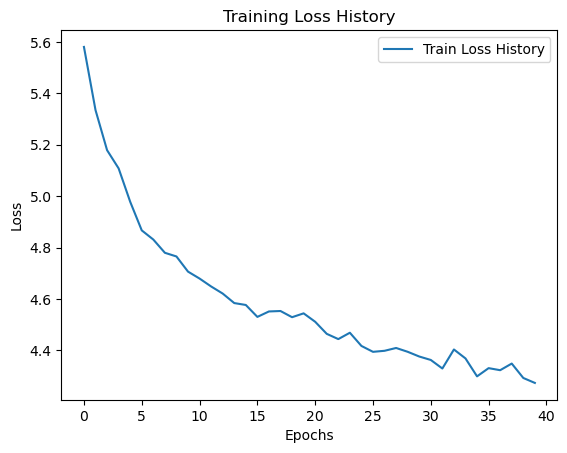

In [8]:
# Plot training loss
plt.plot(train_loss_history, label='Train Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

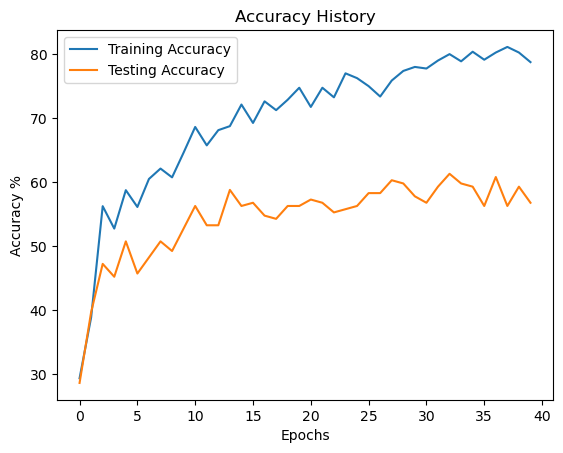

In [9]:
# Plot training loss
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy History')
plt.legend()
plt.show()

In [10]:
def display_confusion_matrix(true_labels, predicted_labels, is_train=False):
    cm = confusion_matrix(torch.cat(true_labels).cpu(), torch.cat(predicted_labels).cpu(), labels=list(range(len(class_names))))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
    
    if is_train:
        plt.title("Training Confusion Matrix")
    else:
        plt.title("Testing Confusion Matrix")
        
    plt.show()

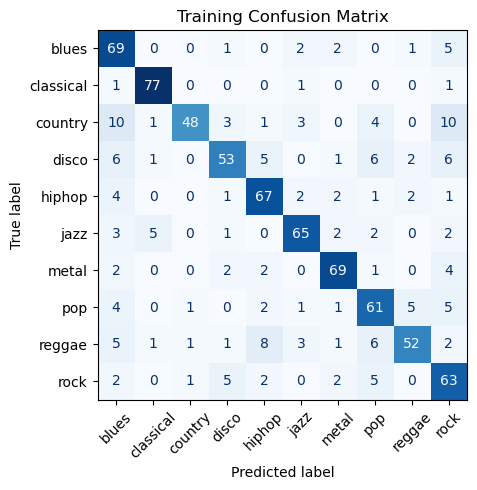

In [11]:
display_confusion_matrix(train_label_true, train_label_pred, is_train=True)

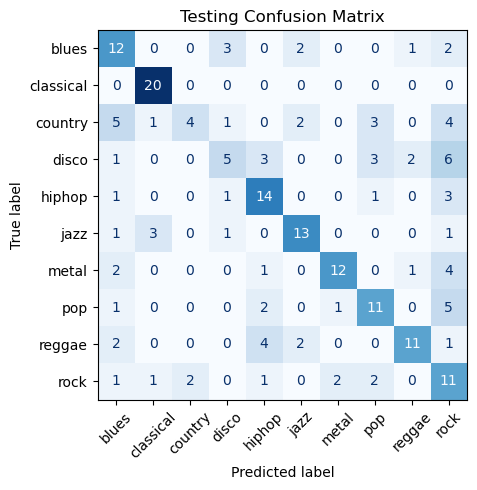

In [12]:
display_confusion_matrix(test_label_true, test_label_pred, is_train=False)